## Cài đặt và Import thư viện

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import random

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


In [2]:
# Cấu hình đường dẫn 
DATA_DIR = '/kaggle/input/chicken-disease-1'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'Train')
CSV_PATH = os.path.join(DATA_DIR, 'train_data.csv')

# Đọc file CSV
df = pd.read_csv(CSV_PATH)
print("Thong tin co ban ve dataset:")
print(f"   Tong so mau: {len(df)}")
print(f"   So cot: {len(df.columns)}")
print("\n5 dong dau tien:")
print(df.head(5))


Thong tin co ban ve dataset:
   Tong so mau: 8067
   So cot: 2

5 dong dau tien:
           images               label
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease


## Chia tập Train/Val/Test (70% - 15% - 15%)

In [3]:
# Tạo mapping giữa nhãn và chỉ số
class_names = sorted(df['label'].unique())
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}
print("Bảng mã hóa nhãn:", class_to_idx)

# CUSTOM DATA SPLIT: 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['label'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

print(f"\nDataset Size:")
print(f"Train: {len(train_df)} ảnh (70%) - Dùng để học")
print(f"Val:   {len(val_df)} ảnh (15%) - Dùng để chỉnh hyperparameters/Early Stopping")
print(f"Test:  {len(test_df)} ảnh (15%) - Dùng để chấm điểm cuối cùng")

print("\nPhân phối nhãn trong tập Train:")
print(train_df['label'].value_counts())

Bảng mã hóa nhãn: {'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}

Dataset Size:
Train: 5646 ảnh (70%) - Dùng để học
Val:   1210 ảnh (15%) - Dùng để chỉnh hyperparameters/Early Stopping
Test:  1211 ảnh (15%) - Dùng để chấm điểm cuối cùng

Phân phối nhãn trong tập Train:
label
Salmonella            1837
Coccidiosis           1733
Healthy               1683
New Castle Disease     393
Name: count, dtype: int64


## Oversampling - Cân bằng dữ liệu

Áp dụng kỹ thuật Random Oversampling để cân bằng tất cả các lớp về số lượng bằng lớp đa số.  
Điều này giúp mô hình học tập công bằng giữa các lớp, đặc biệt với lớp New Castle Disease có ít mẫu.

Phân phối nhãn TRƯỚC oversampling (Train):
label
Salmonella            1837
Coccidiosis           1733
Healthy               1683
New Castle Disease     393
Name: count, dtype: int64
Tổng: 5646 ảnh

Phân phối nhãn SAU oversampling (Train):
label
Healthy               1837
New Castle Disease    1837
Salmonella            1837
Coccidiosis           1837
Name: count, dtype: int64
Tổng: 7348 ảnh


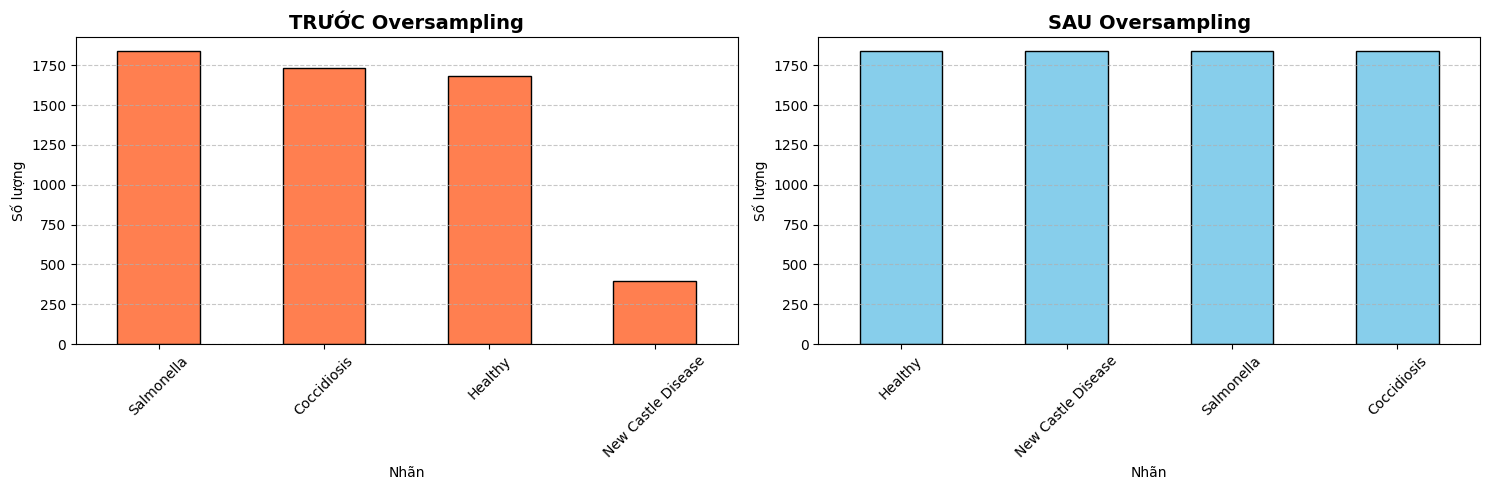

In [4]:
# Hàm balance_all_classes - Oversample tất cả lớp thiểu số
def balance_all_classes(df, target_col='label', seed=42):
    """
    Oversample các lớp thiểu số để tất cả lớp có số lượng bằng lớp đa số
    """
    max_size = df[target_col].value_counts().max()
    lst = [df]
    
    for class_index, group in df.groupby(target_col):
        samples_needed = max_size - len(group)
        if samples_needed > 0:
            # Oversample các lớp ít hơn
            oversampled = group.sample(samples_needed, replace=True, random_state=seed)
            lst.append(oversampled)
    
    # Kết hợp tất cả và xáo trộn
    balanced_df = pd.concat(lst).sample(frac=1, random_state=seed).reset_index(drop=True)
    return balanced_df

# Áp dụng oversampling CHỈ trên tập train
print("Phân phối nhãn TRƯỚC oversampling (Train):")
print(train_df['label'].value_counts())
print(f"Tổng: {len(train_df)} ảnh\n")

train_df_balanced = balance_all_classes(train_df, target_col='label', seed=42)

print("Phân phối nhãn SAU oversampling (Train):")
print(train_df_balanced['label'].value_counts())
print(f"Tổng: {len(train_df_balanced)} ảnh")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trước oversampling
train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('TRƯỚC Oversampling', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nhãn')
axes[0].set_ylabel('Số lượng')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=45)

# Sau oversampling
train_df_balanced['label'].value_counts().plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('SAU Oversampling', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nhãn')
axes[1].set_ylabel('Số lượng')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Data Augmentation và Transforms

Chiến lược tăng cường dữ liệu mạnh cho tập train bao gồm:  
- Rotation (90 độ) - phân gà không có hướng cố định
- Horizontal & Vertical Flip
- Random Affine (shift, scale, shear)
- Color Jitter (brightness, contrast, saturation, hue)
- Random Perspective

In [5]:
# Chuẩn hóa ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Cấu hình
IMG_SIZE = 300

# Transform cho Train (Data Augmentation MẠNH - tương tự file mẫu)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Data Augmentation mạnh
    transforms.RandomRotation(degrees=90),  # Xoay ảnh ngẫu nhiên (phân không có hướng)
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang
    transforms.RandomVerticalFlip(p=0.5),    # Lật dọc
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),  # Dịch chuyển 20%
        scale=(0.8, 1.2),      # Zoom in/out
        shear=10               # Shear/nghiêng
    ),
    transforms.ColorJitter(
        brightness=0.2,   # Thay đổi độ sáng
        contrast=0.2,     # Thay đổi độ tương phản
        saturation=0.2,   # Thay đổi độ bão hòa
        hue=0.1           # Thay đổi màu sắc
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Perspective transform
    # Chuyển sang tensor và normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Transform cho Val và Test (KHÔNG augmentation - chỉ resize và normalize)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


## Tạo Custom Dataset

In [6]:
# CUSTOM DATASET
class ChickenDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Lấy tên ảnh và nhãn
        row = self.dataframe.iloc[idx]
        img_name = row['images']
        label_str = row['label']

        # Đọc ảnh
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Áp dụng transform
        if self.transform:
            image = self.transform(image)
        # Chuyển nhãn thành số
        label = class_to_idx[label_str]

        return image, label

# Tạo Dataset - SỬ DỤNG train_df_balanced (đã oversample)
train_dataset = ChickenDataset(train_df_balanced, TRAIN_IMG_DIR, transform=train_transforms)
val_dataset = ChickenDataset(val_df, TRAIN_IMG_DIR, transform=val_test_transforms)
test_dataset = ChickenDataset(test_df, TRAIN_IMG_DIR, transform=val_test_transforms)

print(f"Train dataset: {len(train_dataset)} ảnh (đã oversample)")
print(f"Val dataset:   {len(val_dataset)} ảnh")
print(f"Test dataset:  {len(test_dataset)} ảnh")

Train dataset: 7348 ảnh (đã oversample)
Val dataset:   1210 ảnh
Test dataset:  1211 ảnh


## Tạo DataLoader

In [7]:
BATCH_SIZE = 32

# Tạo DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train batches: 230
Val batches:   38
Test batches:  38


## CNN Transfer Learning With EfficientNetB3

In [8]:
# EFFICIENTNET-B3 (TRANSFER LEARNING)
def build_model(num_classes):
    
    # Tải model EfficientNet-B3 đã pre-trained
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

    # Unfreeze các layers (cho phép fine-tuning)
    for param in model.features.parameters():
        param.requires_grad = True

    # Thay thế lớp Classifier cuối cùng
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

# Khởi tạo model
model = build_model(num_classes=len(class_names))
model = model.to(device)

print("✓ Model EfficientNetB3 đã được khởi tạo")
print(f"✓ Số lớp output: {len(class_names)}")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 188MB/s] 


✓ Model EfficientNetB3 đã được khởi tạo
✓ Số lớp output: 4


## EarlyStopping

In [9]:
# EARLY STOPPING
class EarlyStopping:
    
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        # Epoch đầu tiên 
        if self.best_score is None:
            self.best_score = score 
            self.save_checkpoint(val_loss, model)
            
        # Score hiện tại KHÔNG tốt hơn best
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        # Score hiện tại TỐT HƠN best
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Config hàm Loss và Optimizer

In [11]:
# Hàm mất mát: CrossEntropyLoss 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-4,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

## Training và Validation Functions

In [12]:
# Training Function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Validation Function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

## Huấn luyện mô hình

In [13]:
NUM_EPOCHS = 30

# Khởi tạo Early Stopping
early_stopping = EarlyStopping(patience=7, verbose=True, path='best_model.pth')

# Lưu trữ metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("=" * 60)
print("BẮT ĐẦU HUẤN LUYỆN")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n⚠ Early stopping triggered!")
        break

print("\n" + "=" * 60)
print("HOÀN THÀNH HUẤN LUYỆN")
print("=" * 60)

BẮT ĐẦU HUẤN LUYỆN

Epoch 1/30
----------------------------------------
Train Loss: 0.6857 | Train Acc: 0.8476
Val Loss:   0.4422 | Val Acc:   0.9603
Validation loss decreased (inf → 0.442193). Saving model...

Epoch 2/30
----------------------------------------
Train Loss: 0.4700 | Train Acc: 0.9464
Val Loss:   0.4136 | Val Acc:   0.9711
Validation loss decreased (0.442193 → 0.413646). Saving model...

Epoch 3/30
----------------------------------------
Train Loss: 0.4415 | Train Acc: 0.9616
Val Loss:   0.4074 | Val Acc:   0.9777
Validation loss decreased (0.413646 → 0.407395). Saving model...

Epoch 4/30
----------------------------------------
Train Loss: 0.4249 | Train Acc: 0.9680
Val Loss:   0.4040 | Val Acc:   0.9769
Validation loss decreased (0.407395 → 0.404033). Saving model...

Epoch 5/30
----------------------------------------
Train Loss: 0.4134 | Train Acc: 0.9731
Val Loss:   0.4003 | Val Acc:   0.9777
Validation loss decreased (0.404033 → 0.400350). Saving model...

Epoch

## Vẽ biểu đồ Training History

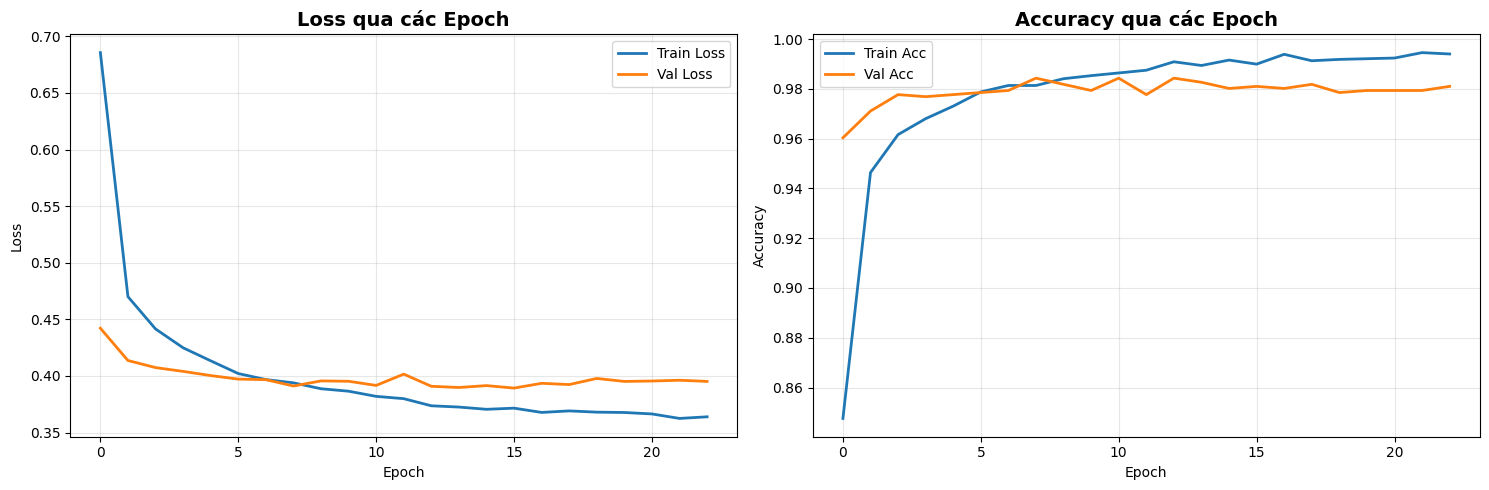

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss qua các Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', linewidth=2)
axes[1].set_title('Accuracy qua các Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Load Best Model và Đánh giá trên Val Set

✓ Best model loaded!

VALIDATION SET - CLASSIFICATION REPORT
                    precision    recall  f1-score   support

       Coccidiosis       0.99      0.98      0.99       371
           Healthy       0.96      0.97      0.97       360
New Castle Disease       1.00      0.99      0.99        85
        Salmonella       0.98      0.99      0.98       394

          accuracy                           0.98      1210
         macro avg       0.98      0.98      0.98      1210
      weighted avg       0.98      0.98      0.98      1210



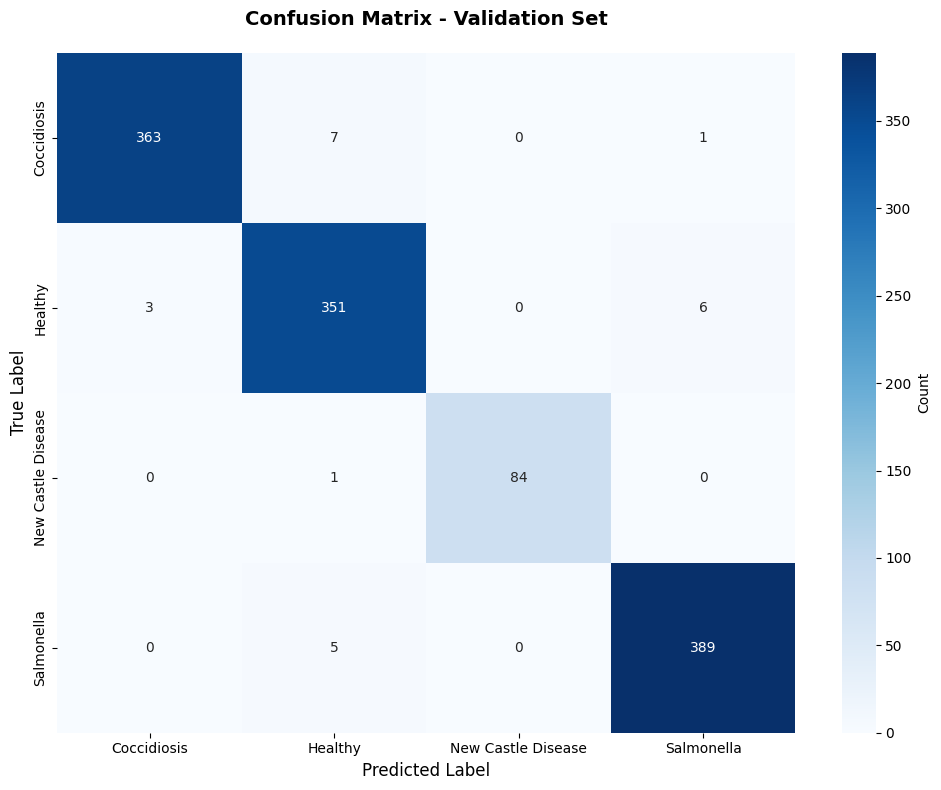

In [22]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("✓ Best model loaded!\n")

# Đánh giá trên Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("=" * 60)
print("VALIDATION SET - CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=list(class_to_idx.keys()),
    digits=2
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

## Đánh giá trên Test Set

TEST SET - CLASSIFICATION REPORT
                    precision    recall  f1-score   support

       Coccidiosis       0.99      0.98      0.98       372
           Healthy       0.97      0.97      0.97       361
New Castle Disease       0.98      0.99      0.98        84
        Salmonella       0.98      0.98      0.98       394

          accuracy                           0.98      1211
         macro avg       0.98      0.98      0.98      1211
      weighted avg       0.98      0.98      0.98      1211



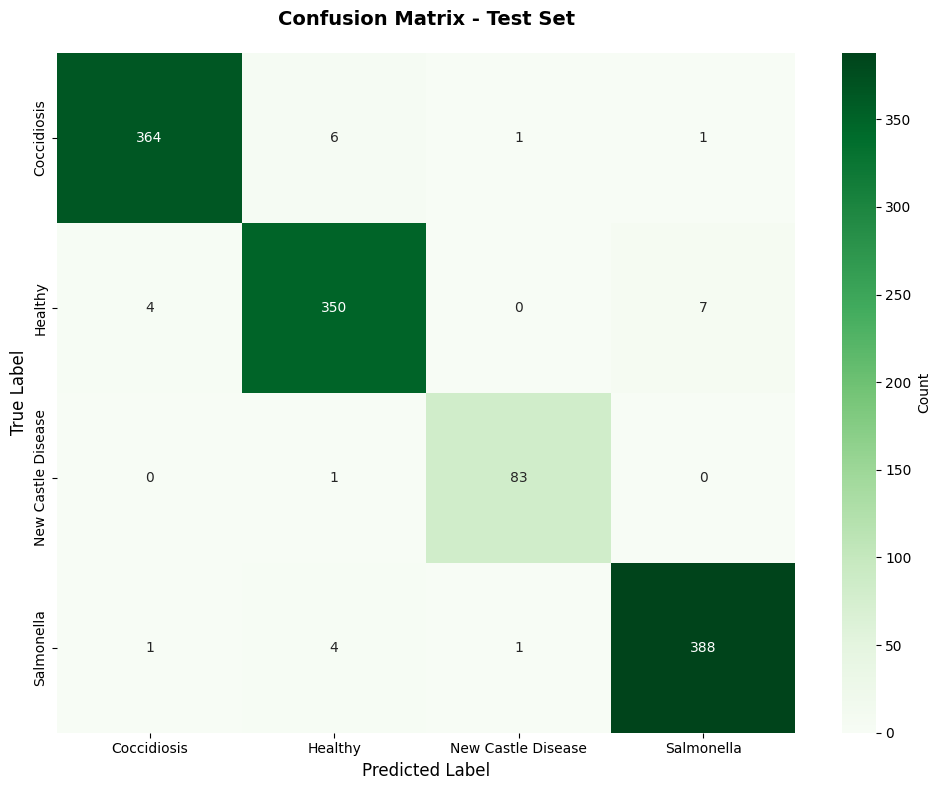


TEST ACCURACY: 0.9785 (97.85%)


In [23]:
# Đánh giá trên Test Set
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.numpy())

# Classification Report for Test Set
print("=" * 60)
print("TEST SET - CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=list(class_to_idx.keys()),
    digits=2
))

# Confusion Matrix for Test Set
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Tính accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\n{'='*60}")
print(f"TEST ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")

## Dự đoán trên ảnh mới

--- KIỂM TRA ẢNH TEST ---
Ground Truth: New Castle Disease



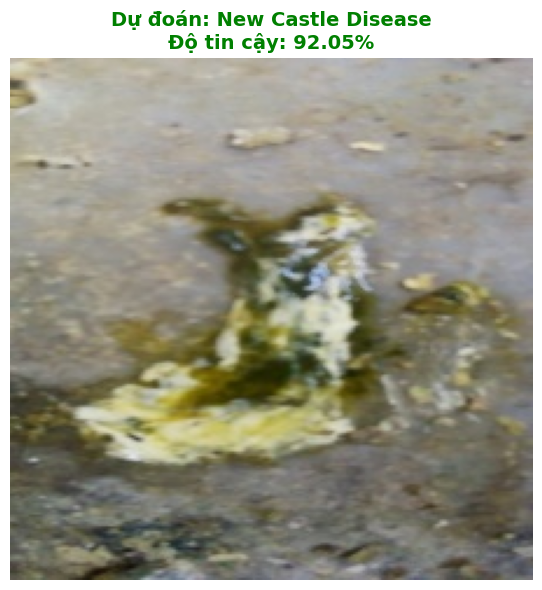

In [18]:
def predict_image(model, image_path, transform):
    model.eval()
    
    # Kiểm tra file tồn tại
    if not os.path.exists(image_path):
        print(f"Lỗi: Không tìm thấy ảnh tại {image_path}")
        return

    image = Image.open(image_path).convert("RGB")
    
    # Transform ảnh
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    class_idx = predicted.item()
    class_name = idx_to_class[class_idx]
    conf_score = confidence.item()

    # Hiển thị ảnh và kết quả
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(
        f"Dự đoán: {class_name}\nĐộ tin cậy: {conf_score*100:.2f}%", 
        fontsize=14, 
        fontweight='bold', 
        color='green' if conf_score > 0.8 else 'orange'
    )
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return class_name, conf_score

# Test với ảnh từ test set
if len(test_df) > 0:
    test_row = test_df.iloc[0]
    test_img_path = os.path.join(TRAIN_IMG_DIR, test_row['images'])
    print(f"--- KIỂM TRA ẢNH TEST ---")
    print(f"Ground Truth: {test_row['label']}\n")
    predict_image(model, test_img_path, val_test_transforms)